In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2
import pickle
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
#Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


##Import data

In [3]:
def read_alphabets(alphabet_directory_path, alphabet_directory_name):
    """
    Reads all the characters from a given alphabet_directory
    """
    datax = []
    datay = []
    characters = os.listdir(alphabet_directory_path)
    for character in characters:
        images = os.listdir(alphabet_directory_path + character + '/')
        for img in images:
            image = cv2.resize(
                cv2.imread(alphabet_directory_path + character + '/' + img),
                (28,28)
                )
            #不数据增广
#             datax.append((image))
#             datay.append((alphabet_directory_name + '_' + character))
            #rotations of image
            rotated_90 = ndimage.rotate(image, 90)
            rotated_180 = ndimage.rotate(image, 180)
            rotated_270 = ndimage.rotate(image, 270)
            #data augmentation 将旋转后的数据训练集，并赋予相应标签
            datax.extend((image, rotated_90, rotated_180, rotated_270))

            datay.extend((
                alphabet_directory_name + '_' + character + '_0',
                alphabet_directory_name + '_' + character + '_90',
                alphabet_directory_name + '_' + character + '_180',
                alphabet_directory_name + '_' + character + '_270'
            ))
            
    return np.array(datax), np.array(datay)

def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None
#     pool = mp.Pool(mp.cpu_count())
#     results = [pool.apply(read_alphabets,
#                           args=(
#                               base_directory + '/' + directory + '/', directory, 
#                               )) for directory in os.listdir(base_directory)]
#     pool.close()
    results = [read_alphabets(base_directory + '/' + directory + '/', directory, 
                              ) for directory in os.listdir(base_directory)]
    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.vstack([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [57]:
def read_mini(directory_path):
    """
    read mini_imagenet
    """
    datax = []
    datay = []
    dirs = os.listdir(directory_path)
    for dir in dirs:
        images = os.listdir(directory_path + dir + '/')
        for img in images:
            image = cv2.imread(directory_path + dir + '/' + img)
#             image = cv2.cvtColor(directory_path + dir + '/' + img, 
#                                  cv2.COLOR_BAYER_BG2BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            datax.append((image))
            datay.append((directory_path + dir))
    return np.array(datax, dtype=object), np.array(datay,dtype=object)

def read_mini_images(directory):
    datax = None 
    datay = None 
    print("1")
    datax, datay = read_mini(directory)
#     print(datax.shape)
#     print(datax)
#     print(datay.shape)
#     for result in results:
#         print(result.shape)
#         if datax is None:
#             datax = result[0]
#             datay = result[1]
#         else:
#             datax = np.vstack([datax, result[0]])
#             datay = np.concatenate([datay, result[1]])
    return datax, datay 

In [58]:
def read_mini_ori(directory_path):
    """
    read mini_imagenet
    """
    datax = []
    datay = []
    dirs = os.listdir(directory_path)
    for dir in dirs:
        images = os.listdir(directory_path + dir + '/')
        for img in images:
            image = cv2.imread(directory_path + dir + '/' + img)
#             image = cv2.cvtColor(directory_path + dir + '/' + img, 
#                                  cv2.COLOR_BAYER_BG2BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            datax.append((image))
            datay.append((directory_path + dir))
    return np.array(datax, dtype=object), np.array(datay,dtype=object)

# def read_mini_images_ori(directory):
#     datax = None 
#     datay = None 
#     print("1")
#     datax, datay = read_mini(directory)
#     return datax, datay 

In [59]:
dataset = 'CUB/'
# dataset = 'mini-imagenet/'
# dataset = 'omniglot/'
# dataset = 'mini2/'

In [60]:
if dataset == 'omniglot/':
#     trainx, trainy = read_images(dataset + 'images_background')
#     testx, testy = read_images(dataset + 'images_evaluation')
    trainx = np.load('omni_trainx.npy')
    trainy = np.load('omni_trainy.npy')
    testx = np.load('omni_testx.npy')
    testy = np.load('omni_testy.npy')
if dataset == 'mini-imagenet/':
    trainx, trainy = read_mini_images(dataset + 'train/')
    testx, testy = read_mini_images(dataset + 'test/')
#     trainx = np.load('mini_trainx.npy')
#     trainy = np.load('mini_trainy.npy')
#     testx = np.load('mini_testx.npy')
#     testy = np.load('mini_testy.npy')
    
if dataset == 'mini2/':
#     trainx, trainy = read_mini_ori(dataset + 'train/')
#     valx, valy = read_mini_ori(dataset + 'val/')
#     testx, testy = read_mini_ori(dataset + 'test/')
    trainx = np.load('mini144_trainx.npy')
    trainy = np.load('mini144_trainy.npy') 
    testx = np.load('mini144_testx.npy')
    testy = np.load('mini144_testy.npy')
    
if dataset == 'CUB/':
    trainx, trainy = read_mini_images(dataset + 'train/')
    testx, testy = read_mini_images(dataset + 'test/')
#     trainx, trainy = read_mini_ori(dataset + 'train/')
#     valx, valy = read_mini_ori(dataset + 'val/')
#     testx, testy = read_mini_ori(dataset + 'test/')

1
1


In [62]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((5864,), (5864,), (2966,), (2966,))

In [63]:
#  valx.shape, valy.shape

In [65]:
# np.save('omni_trainx', trainx)
# np.save('omni_trainy', trainy)
# np.save('omni_testx', testx)
# np.save('omni_testy', testy)

# np.save('omni_pro_trainx', trainx)
# np.save('omni_pro_trainy', trainy)
# np.save('omni_pro_testx', testx)
# np.save('omni_pro_testy', testy)

# np.save('mini_trainx', trainx)
# np.save('mini_trainy', trainy)
# np.save('mini_testx', testx)
# np.save('mini_testy', testy)


# np.save('mini144_trainx', trainx)
# np.save('mini144_trainy', trainy)
# np.save('mini144_testx', testx)
# np.save('mini144_testy', testy)

# np.save('cub_trainx', trainx)
# np.save('cub_trainy', trainy)
# np.save('cub_testx', testx)
# np.save('cub_testy', testy)


In [66]:
# path = 'D:/pickles'
# output = open(path, 'wb')
# pickle.dump(train_x, output)
# path = "D:/pickles"   #文件路径
# with open(path , "rb") as fh:
#     data = pickle.load(fh)

In [67]:
trainy 

array(['CUB/train/Acadian_Flycatcher', 'CUB/train/Acadian_Flycatcher',
       'CUB/train/Acadian_Flycatcher', ...,
       'CUB/train/Yellow_headed_Blackbird',
       'CUB/train/Yellow_headed_Blackbird',
       'CUB/train/Yellow_headed_Blackbird'], dtype=object)

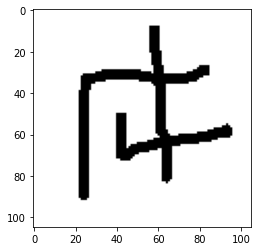

In [68]:
test_dir = 'omniglot/images_background/Japanese_(hiragana)/character14/0501_01.png'
testimg = cv2.imread(test_dir)
rotated_90 = ndimage.rotate(testimg, 90)
rotated_180 = ndimage.rotate(testimg, 180)
rotated_270 = ndimage.rotate(testimg, 270)
# plt.imshow(testimg)
# plt.imshow(rotated_90) 
# plt.imshow(rotated_180)
plt.imshow(rotated_270)

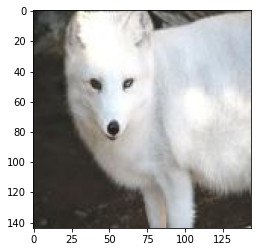

In [69]:
test_dir = 'mini2/train/n02120079/n0212007900000507.jpg'
# testimg = cv2.resize(cv2.imread(test_dir), (224, 224))
testimg = cv2.imread(test_dir)
testimg = cv2.cvtColor(testimg, cv2.COLOR_BGR2RGB)
flip_img = cv2.flip(testimg, 1)
plt.imshow(testimg), type(testimg)
plt.imshow(flip_img)

The training set contains 77,120 images (from 964 * 4 = 3,856 characters in images_background) and the testing set contains 52,720 images (from 659 * 4 = 2,636 characters in images_evaluation).

##Create samples

In [70]:
def extract_sample(n_way, n_support, n_query, datax, datay):
  """
  Picks random sample of size n_support+n_querry, for n_way classes
  Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
  Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
  """
  sample = []
  #随机抽取n_way个标签类别，每个标签有20张图
  K = np.random.choice(np.unique(datay), n_way, replace=False)
  for cls in K:
    #拿出每个标签内的20张图, 即，只拿出 标签==随机抽取的cls中的标签 的那20张
    #datay == cls 是一个77120 * 1的矩阵，其中只有标签相等位置为True，会被拿出，python语法！！
    datax_cls = datax[datay == cls]
    #随机打乱
    perm = np.random.permutation(datax_cls)
    #取前support set中每类图片数+query set每类图片数 张图片，分别作为se和qe
    sample_cls = perm[:(n_support+n_query)]
    #sample是一个五维数组，第一维可以理解为目前class的数量
    sample.append(sample_cls)
  sample = np.array(sample)
  sample = torch.from_numpy(sample).float()
  #将维度打乱为e.g.8个task [8, 10, 3, 28, 28], but why?
  sample = sample.permute(0,1,4,2,3)
  img_dim = sample.shape[2:]
  return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query,
      'class_name': K,
      'img_dim':img_dim
      })

In [71]:
def display_sample(sample):
    """
    Displays sample in a grid
    Args:
        sample (torch.Tensor): sample of images to display
    """
    #need 4D tensor to create grid, currently 5D
    print(sample.shape)
    sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
    #make a grid
    #每行10张图片
    print(sample_4D.shape)
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
    print(out.shape)
    print(out.permute(1, 2, 0).shape)
    plt.figure(figsize = (80,8))
    ##！！！！！注意转unit8，不然图像显示有问题
    plt.imshow(out.permute(1, 2, 0).numpy().astype(np.uint8))
    print(type(out.permute(1,2,0).numpy().astype(np.uint8)))
    return out.permute(1, 2, 0).numpy().astype(np.uint8)

As an example, let's pick a sample and display it

*   n_way = 8
*   n_support = 5
*   n_query = 5




In [72]:
sample_example = extract_sample(5, 5, 0, trainx, trainy)
get_image = display_sample(sample_example['images'])
#type : np.ndarray
print(sample_example['class_name'])
print(sample_example['class_name'].shape)
sample_example['images'].shape


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
def display_support_query(sam):
    support = sam['n_support']
    query = sam['n_query']
    sam_support = sam['images'][:, :support]
    sam_query = sam['images'][:, support:]
    support_4D = sam_support.reshape(sam_support.shape[0] * sam_support.shape[1],
                              *sam_support.shape[2:])
    out_support = torchvision.utils.make_grid(support_4D, nrow = sam_support.shape[1])
    query_4D = sam_query.reshape(sam_query.shape[0] * sam_query.shape[1], 
                             *sam_query.shape[2:])
    out_query = torchvision.utils.make_grid(query_4D, nrow = sam_query.shape[1])
    fig = plt.figure(figsize=(16, 7))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax1.imshow(out_support.permute(1, 2, 0).numpy().astype(np.uint8))
    ax2.imshow(out_query.permute(1, 2, 0).numpy().astype(np.uint8))
    return out_support, out_query

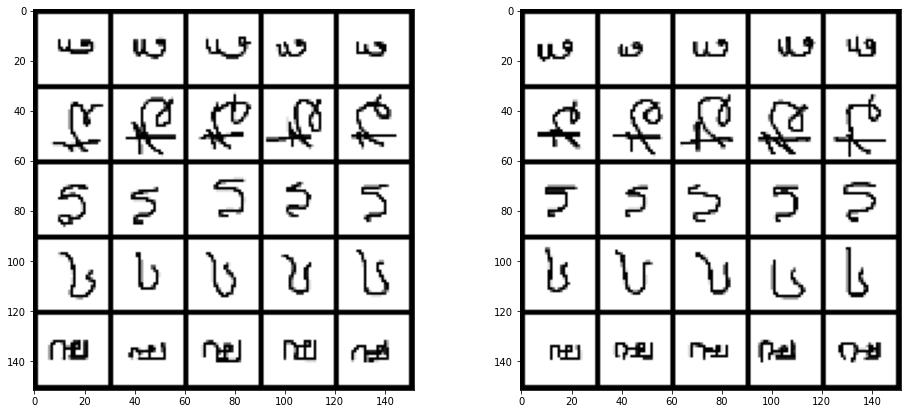

In [94]:
sam = extract_sample(5, 5, 5, trainx, trainy)
support, query = display_support_query(sam)

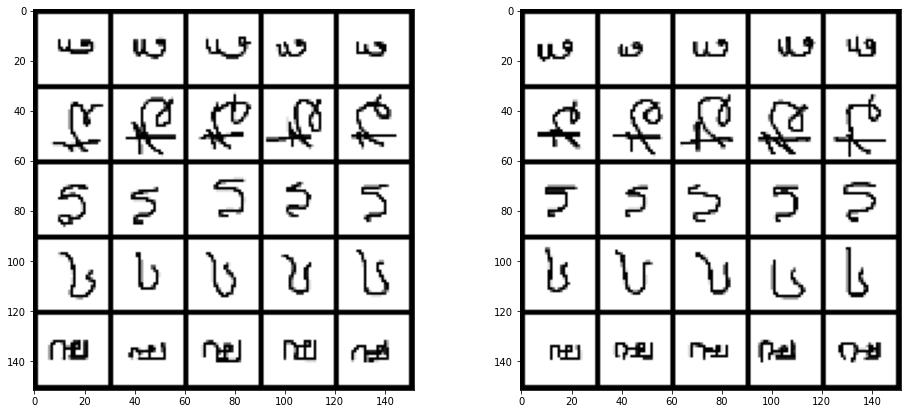

In [95]:
fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(support.permute(1, 2, 0).numpy().astype(np.uint8))
ax2.imshow(query.permute(1, 2, 0).numpy().astype(np.uint8))

In [96]:
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

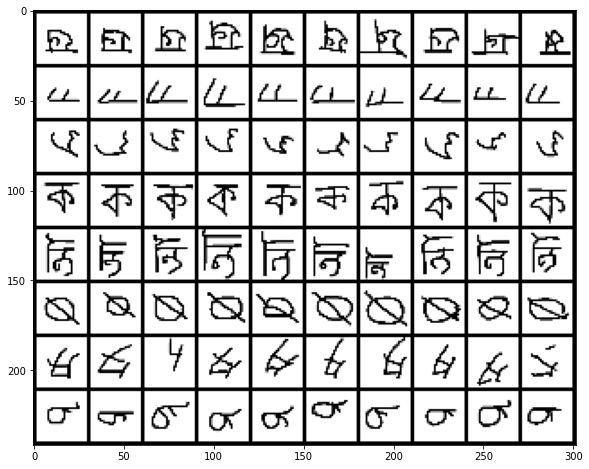

In [97]:
plt.figure(figsize=(80,8))
plt.imshow(get_image)

##Build model

In [98]:
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
    #拉成输入向量第一维*通道数？
    return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
  """
  Loads the prototypical network model
  Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
  Returns:
      Model (Class ProtoNet)
  """
  x_dim = kwargs['x_dim']
  hid_dim = kwargs['hid_dim']
  z_dim = kwargs['z_dim']

  def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        #对数据进行归一化处理
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )
    
  encoder = nn.Sequential(
    conv_block(x_dim[0], hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, z_dim),
    Flatten()
    )
    
  return ProtoNet(encoder)

In [99]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    Args:
        encoder : CNN encoding the images in sample
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
    """
    #encoder相当于是embbedding部分的CNN？
    super(ProtoNet, self).__init__()
    self.encoder = encoder.cuda()

  def set_forward_loss(self, sample):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    sample_images = sample['images'].cuda()
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']
    class_name = sample['class_name']
    
    #e.g. 取出的shape为[8, 5, 3, 28, 28],即每类五张图作为support set
    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]
   
    #target indices are 0 ... n_way-1
        #生成一个8*5*1的张量
    target_inds = torch.arange(0, n_way).view(n_way, 
                                                1, 1).expand(n_way, n_query, 1).long()
#     print("traget_inds shape", target_inds.shape)
    target_inds = Variable(target_inds, requires_grad=False)
    target_inds = target_inds.cuda()
   
    #encode images of the support and the query set
    #support set和query set前两维合并（即size[40, 3, 28, 28]）
    #并把两个集合按照第一维叠加[80, 3, 28, 28]
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
   
    #encoder是一系列卷积层，先做embbeding，提取成连续向量
    z = self.encoder.forward(x)
    #卷积层输出的通道数
    #输出的是80个长度为64的向量
#     print("embbeding shape: ", z.shape)
    z_dim = z.size(-1) #usually 64
    #前40（n_way*n_support）个是support set，
    #将其每类的图片求和（即形成一个原型），获得n_way个长为64的特征向量（即原型）
    z_proto_t =  z[:n_way*n_support].view(n_way, n_support, z_dim)
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
#     print("proto shape(before mean):", z_proto_t.shape)
#     print("proto shape:", z_proto.shape)
    z_query = z[n_way*n_support:]
#     print('query shape', z_query.shape)

    #compute distances
    dists = euclidean_dist(z_query, z_proto)
#     print('dist shape', dists.shape)
    #compute probabilities
    #-dists:距离越小的说明越可能是那一类，softmax后应该越大
    # view:将40张query再次分割为原来的8类每类5张，
    # [8,5,8]表示现在8类每类5张图片中，每张对应8个原型的可能性
    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
#     print('logpy shape', log_p_y.shape)
    loss_val_t = -log_p_y.gather(2, target_inds)
#     print('logpy after gather ', loss_val_t.shape)
    #评估损失，应该是选取正确的标签类， but why?
    #target_int 顺序排列，表示正确标签，如第一行的标签应当为0，如果预测的不是为0则错了
    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
#     print('loss_val', loss_val.item())
    #y_hat 预测成了哪一类
    _, y_hat = log_p_y.max(2)
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
   
    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }

In [100]:
def euclidean_dist(x, y):
  """
  Computes euclidean distance btw x and y
  Args:
      x (torch.Tensor): shape (n, d). n usually n_way*n_query
      y (torch.Tensor): shape (m, d). m usually n_way
  Returns:
      torch.Tensor: shape(n, m). For each query, the distances to each centroid
  """
  n = x.size(0) #40
  m = y.size(0) #8
  d = x.size(1) #64
  assert d == y.size(1)
#在第n维增加一个维度
#每个query分别与每个原型proto作欧几里得距离
  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

In [101]:
if dataset == 'omniglot/':
    model_test = load_protonet_conv(
                            x_dim=(3,28,28),
                            hid_dim=64,
                            z_dim=64,
                            )
if dataset == 'mini-imagenet/':
    model_test = load_protonet_conv(
                            x_dim=(3,84,84),
                            hid_dim=64,
                            z_dim=64,
                            )
if dataset == 'mini2/':
    model_test = load_protonet_conv(
                            x_dim=(3,144,144),
                            hid_dim=64,
                            z_dim=64,
                            )
n_way = 8
n_support = 5
n_query = 5 
sample = extract_sample(n_way, n_support, n_query, trainx, trainy)
loss, output = model_test.set_forward_loss(sample)
output

{'loss': 1.2560018301010132,
 'acc': 0.675000011920929,
 'y_hat': tensor([[0, 0, 0, 1, 0],
         [5, 1, 1, 1, 1],
         [2, 2, 0, 4, 1],
         [3, 3, 6, 4, 3],
         [4, 1, 4, 4, 4],
         [5, 2, 1, 0, 5],
         [6, 6, 6, 6, 6],
         [7, 3, 7, 4, 7]], device='cuda:0')}

##Train

In [102]:
from tqdm import tqdm_notebook
from tqdm import tnrange

In [103]:
def train(model, optimizer, train_x, train_y, 
          n_way, n_support, n_query, max_epoch, epoch_size, decay_every):
  """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
  #divide the learning rate by 2 at each epoch, as suggested in paper
    scheduler = optim.lr_scheduler.StepLR(optimizer, decay_every, gamma=0.5, last_epoch=-1)
    epoch = 0 #epochs done so far
    stop = False #status to know when to stop

#5个epoch，每个epoch2000个episodes
#改为200个epoch，每个epoch100个episodes
    while epoch < max_epoch and not stop:
        running_loss = 0.0
        running_acc = 0.0

    for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
        sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
        optimizer.zero_grad()
        loss, output = model.set_forward_loss(sample)
        running_loss += output['loss']
        running_acc += output['acc']
        loss.backward()
        optimizer.step()
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
    epoch += 1
    scheduler.step()

In [104]:

if dataset == 'omniglot/':
    model = load_protonet_conv(
                            x_dim=(3,28,28),
                            hid_dim=64,
                            z_dim=64,
                            )
    n_way = 60
    n_support = 5
    n_query = 5
if dataset == 'mini-imagenet/':
    model = load_protonet_conv(
                            x_dim=(3,84,84),
                            hid_dim=64,
                            z_dim=64,
                            )
    n_way = 20
    n_support = 5
    n_query = 5

    
if dataset == 'mini2/':
    model = load_protonet_conv(
                            x_dim=(3,144,144),
                            hid_dim=64,
                            z_dim=64,
                            )
    n_way = 20
    n_support = 5
    n_query = 5





In [105]:
# static_dict = torch.load('4_5param.pkl')
# model.load_state_dict(static_dict)

In [106]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)


train_x = trainx
train_y = trainy

max_epoch = 100
epoch_size = 100
decay_every = 20

In [107]:
%%time
train(model, optimizer, train_x, train_y, n_way,
      n_support, n_query, max_epoch, epoch_size, decay_every)

C:\Users\CamTrik\AppData\Local\Temp/ipykernel_5404/1529962290.py:26: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 -- Loss: 0.5373 Acc: 0.8524


Epoch 2 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2 -- Loss: 0.2086 Acc: 0.9364


Epoch 3 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3 -- Loss: 0.1609 Acc: 0.9507


Epoch 4 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4 -- Loss: 0.1306 Acc: 0.9595


Epoch 5 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 5 -- Loss: 0.1156 Acc: 0.9635


Epoch 6 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 6 -- Loss: 0.1040 Acc: 0.9671


Epoch 7 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 7 -- Loss: 0.0970 Acc: 0.9701


Epoch 8 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 8 -- Loss: 0.0856 Acc: 0.9719


Epoch 9 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 9 -- Loss: 0.0873 Acc: 0.9717


Epoch 10 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10 -- Loss: 0.0806 Acc: 0.9737


Epoch 11 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 11 -- Loss: 0.0772 Acc: 0.9748


Epoch 12 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 12 -- Loss: 0.0785 Acc: 0.9750


Epoch 13 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 13 -- Loss: 0.0775 Acc: 0.9752


Epoch 14 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 14 -- Loss: 0.0664 Acc: 0.9777


Epoch 15 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 15 -- Loss: 0.0688 Acc: 0.9781


Epoch 16 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 16 -- Loss: 0.0671 Acc: 0.9774


Epoch 17 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 17 -- Loss: 0.0627 Acc: 0.9792


Epoch 18 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 18 -- Loss: 0.0642 Acc: 0.9777


Epoch 19 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 19 -- Loss: 0.0626 Acc: 0.9793


Epoch 20 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 20 -- Loss: 0.0588 Acc: 0.9801


Epoch 21 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 21 -- Loss: 0.0516 Acc: 0.9814


Epoch 22 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 22 -- Loss: 0.0572 Acc: 0.9801


Epoch 23 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 23 -- Loss: 0.0524 Acc: 0.9820


Epoch 24 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 24 -- Loss: 0.0487 Acc: 0.9831


Epoch 25 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 25 -- Loss: 0.0513 Acc: 0.9811


Epoch 26 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 26 -- Loss: 0.0490 Acc: 0.9827


Epoch 27 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 27 -- Loss: 0.0450 Acc: 0.9836


Epoch 28 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 28 -- Loss: 0.0464 Acc: 0.9841


Epoch 29 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 29 -- Loss: 0.0496 Acc: 0.9823


Epoch 30 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 30 -- Loss: 0.0467 Acc: 0.9828


Epoch 31 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 31 -- Loss: 0.0440 Acc: 0.9848


Epoch 32 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 32 -- Loss: 0.0431 Acc: 0.9846


Epoch 33 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 33 -- Loss: 0.0462 Acc: 0.9844


Epoch 34 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 34 -- Loss: 0.0454 Acc: 0.9840


Epoch 35 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 35 -- Loss: 0.0454 Acc: 0.9835


Epoch 36 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 36 -- Loss: 0.0489 Acc: 0.9825


Epoch 37 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 37 -- Loss: 0.0480 Acc: 0.9818


Epoch 38 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 38 -- Loss: 0.0409 Acc: 0.9855


Epoch 39 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 39 -- Loss: 0.0389 Acc: 0.9862


Epoch 40 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 40 -- Loss: 0.0454 Acc: 0.9833


Epoch 41 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 41 -- Loss: 0.0386 Acc: 0.9861


Epoch 42 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 42 -- Loss: 0.0389 Acc: 0.9859


Epoch 43 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 43 -- Loss: 0.0404 Acc: 0.9849


Epoch 44 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 44 -- Loss: 0.0344 Acc: 0.9873


Epoch 45 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 45 -- Loss: 0.0398 Acc: 0.9863


Epoch 46 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 46 -- Loss: 0.0348 Acc: 0.9874


Epoch 47 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 47 -- Loss: 0.0363 Acc: 0.9868


Epoch 48 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 48 -- Loss: 0.0326 Acc: 0.9883


Epoch 49 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 49 -- Loss: 0.0364 Acc: 0.9859


Epoch 50 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 50 -- Loss: 0.0364 Acc: 0.9867


Epoch 51 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 51 -- Loss: 0.0320 Acc: 0.9878


Epoch 52 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 52 -- Loss: 0.0362 Acc: 0.9859


Epoch 53 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 53 -- Loss: 0.0329 Acc: 0.9879


Epoch 54 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 54 -- Loss: 0.0325 Acc: 0.9876


Epoch 55 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 55 -- Loss: 0.0296 Acc: 0.9889


Epoch 56 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 56 -- Loss: 0.0354 Acc: 0.9870


Epoch 57 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 57 -- Loss: 0.0369 Acc: 0.9863


Epoch 58 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 58 -- Loss: 0.0337 Acc: 0.9866


Epoch 59 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 59 -- Loss: 0.0298 Acc: 0.9892


Epoch 60 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 60 -- Loss: 0.0311 Acc: 0.9878


Epoch 61 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 61 -- Loss: 0.0324 Acc: 0.9877


Epoch 62 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 62 -- Loss: 0.0314 Acc: 0.9879


Epoch 63 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 63 -- Loss: 0.0346 Acc: 0.9864


Epoch 64 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 64 -- Loss: 0.0278 Acc: 0.9891


Epoch 65 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 65 -- Loss: 0.0301 Acc: 0.9884


Epoch 66 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 66 -- Loss: 0.0287 Acc: 0.9891


Epoch 67 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 67 -- Loss: 0.0306 Acc: 0.9879


Epoch 68 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 68 -- Loss: 0.0275 Acc: 0.9897


Epoch 69 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 69 -- Loss: 0.0268 Acc: 0.9900


Epoch 70 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 70 -- Loss: 0.0352 Acc: 0.9860


Epoch 71 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 71 -- Loss: 0.0284 Acc: 0.9889


Epoch 72 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 72 -- Loss: 0.0278 Acc: 0.9901


Epoch 73 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 73 -- Loss: 0.0310 Acc: 0.9884


Epoch 74 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 74 -- Loss: 0.0328 Acc: 0.9865


Epoch 75 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 75 -- Loss: 0.0313 Acc: 0.9879


Epoch 76 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 76 -- Loss: 0.0291 Acc: 0.9888


Epoch 77 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 77 -- Loss: 0.0282 Acc: 0.9891


Epoch 78 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 78 -- Loss: 0.0304 Acc: 0.9880


Epoch 79 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 79 -- Loss: 0.0283 Acc: 0.9894


Epoch 80 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 80 -- Loss: 0.0286 Acc: 0.9889


Epoch 81 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 81 -- Loss: 0.0277 Acc: 0.9891


Epoch 82 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 82 -- Loss: 0.0248 Acc: 0.9912


Epoch 83 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 83 -- Loss: 0.0255 Acc: 0.9903


Epoch 84 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 84 -- Loss: 0.0250 Acc: 0.9904


Epoch 85 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 85 -- Loss: 0.0285 Acc: 0.9885


Epoch 86 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 86 -- Loss: 0.0302 Acc: 0.9885


Epoch 87 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 87 -- Loss: 0.0237 Acc: 0.9913


Epoch 88 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 88 -- Loss: 0.0244 Acc: 0.9914


Epoch 89 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 89 -- Loss: 0.0251 Acc: 0.9902


Epoch 90 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 90 -- Loss: 0.0276 Acc: 0.9885


Epoch 91 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 91 -- Loss: 0.0272 Acc: 0.9896


Epoch 92 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 92 -- Loss: 0.0260 Acc: 0.9902


Epoch 93 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 93 -- Loss: 0.0233 Acc: 0.9912


Epoch 94 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 94 -- Loss: 0.0257 Acc: 0.9902


Epoch 95 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 95 -- Loss: 0.0251 Acc: 0.9904


Epoch 96 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 96 -- Loss: 0.0255 Acc: 0.9893


Epoch 97 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 97 -- Loss: 0.0275 Acc: 0.9891


Epoch 98 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 98 -- Loss: 0.0252 Acc: 0.9897


Epoch 99 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 99 -- Loss: 0.0258 Acc: 0.9905


Epoch 100 train:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 100 -- Loss: 0.0255 Acc: 0.9902
Wall time: 15min 47s


In [136]:
if dataset == 'mini-imagenet/':
    torch.save(model, '4_16model.pkl')
    torch.save(model.state_dict(), '4_16param.pkl')
if dataset == 'omniglot/':
    torch.save(model, '4_17omni.pkl')
    torch.save(model.state_dict(), '4_17omni.pkl')

##Test

In [137]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    """
    Tests the protonet
    Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
    """
    running_loss = 0.0
    running_acc = 0.0
    for episode in tnrange(test_episode):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output = model.set_forward_loss(sample)
        running_loss += output['loss']
        running_acc += output['acc']
    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [146]:
# load models 
# mini-imagenet 
if dataset == 'mini-imagenet/':
    static_dict = torch.load('4_4param.pkl')
    model.load_state_dict(static_dict)
if dataset == 'omniglot/':
    static_dict = torch.load('protoNetState1.pkl')
    model.load_state_dict(static_dict)

In [147]:
n_way = 5
n_support = 5
n_query = 5

test_x = testx
test_y = testy

test_episode = 100

test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

C:\Users\CamTrik\AppData\Local\Temp/ipykernel_5404/595578314.py:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(test_episode):


  0%|          | 0/100 [00:00<?, ?it/s]

Test results -- Loss: 0.9022 Acc: 0.6476


##Test on specific example

Let's test the model on a specific example to visualize how well does it label the data

torch.Size([5, 10, 3, 84, 84])
torch.Size([50, 3, 84, 84])
torch.Size([3, 432, 862])
torch.Size([432, 862, 3])
<class 'numpy.ndarray'>
class_names:
 ['mini-imagenet/test/trifle' 'mini-imagenet/test/electric_guitar'
 'mini-imagenet/test/scoreboard' 'mini-imagenet/test/hourglass'
 'mini-imagenet/test/crate']


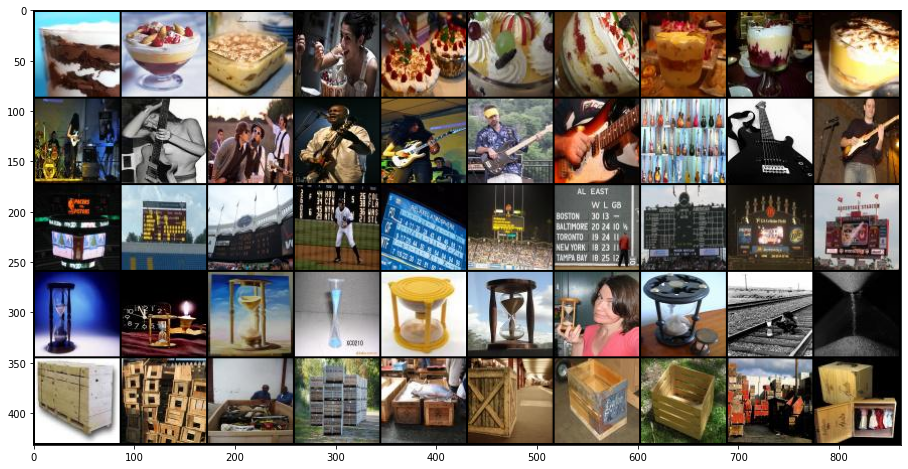

In [36]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])
print('class_names:\n',my_sample['class_name'])

In [37]:
my_loss, my_output = model.set_forward_loss(my_sample)

In [38]:
my_output

{'loss': 0.9854331612586975,
 'acc': 0.6800000071525574,
 'y_hat': tensor([[0, 0, 0, 0, 0],
         [2, 3, 2, 1, 0],
         [2, 2, 2, 3, 2],
         [3, 3, 3, 4, 3],
         [4, 2, 4, 2, 4]], device='cuda:0')}

In [39]:
loss = my_output['loss']
loss 

0.9854331612586975

In [40]:
type(loss)

float

In [41]:
y_hat = my_output['y_hat']
y_hat = y_hat.cpu()

In [42]:
y_hat = y_hat.numpy()

In [43]:
type(y_hat)

numpy.ndarray

In [44]:
y_hat

array([[0, 0, 0, 0, 0],
       [2, 3, 2, 1, 0],
       [2, 2, 2, 3, 2],
       [3, 3, 3, 4, 3],
       [4, 2, 4, 2, 4]], dtype=int64)

In [45]:
class_names = my_sample['class_name']
class_names

array(['mini-imagenet/test/trifle', 'mini-imagenet/test/electric_guitar',
       'mini-imagenet/test/scoreboard', 'mini-imagenet/test/hourglass',
       'mini-imagenet/test/crate'], dtype='<U38')

In [46]:
labels =  []
for indice in y_hat:
    for string in class_names[indice]:
        label = string.split('/')[-1]
        labels.append(label)


In [47]:
labels = np.array(labels)
labels

array(['trifle', 'trifle', 'trifle', 'trifle', 'trifle', 'scoreboard',
       'hourglass', 'scoreboard', 'electric_guitar', 'trifle',
       'scoreboard', 'scoreboard', 'scoreboard', 'hourglass',
       'scoreboard', 'hourglass', 'hourglass', 'hourglass', 'crate',
       'hourglass', 'crate', 'scoreboard', 'crate', 'scoreboard', 'crate'],
      dtype='<U15')

In [48]:
labels.reshape(5, 5)

array([['trifle', 'trifle', 'trifle', 'trifle', 'trifle'],
       ['scoreboard', 'hourglass', 'scoreboard', 'electric_guitar',
        'trifle'],
       ['scoreboard', 'scoreboard', 'scoreboard', 'hourglass',
        'scoreboard'],
       ['hourglass', 'hourglass', 'hourglass', 'crate', 'hourglass'],
       ['crate', 'scoreboard', 'crate', 'scoreboard', 'crate']],
      dtype='<U15')

In [49]:
#输出预测的label名
def label_predicted_transfer(output, sample):
    y_hat = output['y_hat']
    y_hat = y_hat.cpu()
    y_hat = y_hat.numpy()
    class_names = sample['class_name']
    labels = []
    #以y_hat的每一行为索引,找出预测结果对应的label名
    for indice in y_hat:
        for string in class_names[indice]:
            #分割出最后一个/后的字段,即label名
            label = string.split('/')[-1]
            labels.append(label)
    labels = np.array(labels)
    
    labels = labels.reshape(5, 5)
    return labels

In [50]:
predict_labels = label_predicted_transfer(my_output, my_sample)
predict_labels

array([['trifle', 'trifle', 'trifle', 'trifle', 'trifle'],
       ['scoreboard', 'hourglass', 'scoreboard', 'electric_guitar',
        'trifle'],
       ['scoreboard', 'scoreboard', 'scoreboard', 'hourglass',
        'scoreboard'],
       ['hourglass', 'hourglass', 'hourglass', 'crate', 'hourglass'],
       ['crate', 'scoreboard', 'crate', 'scoreboard', 'crate']],
      dtype='<U15')

In [213]:
def label_transfer(sample):
    class_names = sample['class_name']
    labels = []
    for string in class_names:
        label = string.split('/')[-1]
        labels.append(label)
    labels = np.array(labels)
    return labels 

In [214]:
true_labels = label_transfer(my_sample)
true_labels

array(['trifle', 'electric_guitar', 'scoreboard', 'hourglass', 'crate'],
      dtype='<U15')

In [215]:
predict_labels.shape, true_labels.shape 

((5, 5), (5,))

In [216]:
item = np.insert(predict_labels, 0, true_labels, axis=1)
item

array([['trifle', 'trifle', 'trifle', 'trifle', 'trifle', 'trifle'],
       ['electric_guitar', 'scoreboard', 'hourglass', 'scoreboard',
        'electric_guitar', 'trifle'],
       ['scoreboard', 'scoreboard', 'scoreboard', 'scoreboard',
        'hourglass', 'scoreboard'],
       ['hourglass', 'hourglass', 'hourglass', 'hourglass', 'crate',
        'hourglass'],
       ['crate', 'crate', 'scoreboard', 'crate', 'scoreboard', 'crate']],
      dtype='<U15')

In [217]:
acc_class = []
for i_class in item:
    true_num = -1.0
    false_num = 0.0
    for index in i_class:
        if i_class[0] == index:
            true_num += 1 
        else:
            false_num += 1
    acc_this = true_num / n_query
    acc_class.append(acc_this)

In [218]:
acc_class = np.array(acc_class)

In [219]:
item = np.insert(item, n_query + 1, acc_class, axis=1)
item 

array([['trifle', 'trifle', 'trifle', 'trifle', 'trifle', 'trifle',
        '1.0'],
       ['electric_guitar', 'scoreboard', 'hourglass', 'scoreboard',
        'electric_guitar', 'trifle', '0.2'],
       ['scoreboard', 'scoreboard', 'scoreboard', 'scoreboard',
        'hourglass', 'scoreboard', '0.8'],
       ['hourglass', 'hourglass', 'hourglass', 'hourglass', 'crate',
        'hourglass', '0.8'],
       ['crate', 'crate', 'scoreboard', 'crate', 'scoreboard', 'crate',
        '0.6']], dtype='<U15')

In [220]:
len(item)

5

In [221]:
len(item[0])

7

In [222]:
pre_acc = np.arange(2)

In [223]:
pre_acc_class = item[:, -1]

In [224]:
pre_acc_class

array(['1.0', '0.2', '0.8', '0.8', '0.6'], dtype='<U15')

In [225]:
pre_class_name = item[:, 0]

In [226]:
pre_class_name

array(['trifle', 'electric_guitar', 'scoreboard', 'hourglass', 'crate'],
      dtype='<U15')

In [77]:
pre_acc_class.astype(float)

array([1. , 0.2, 0.8, 0.8, 0.6])

In [165]:
i = 0
sname = []
for string in pre_class_name:
    if(len(string) > 3):
        sname.append(string[:3])
    else:
        sname.append(string)


In [162]:
pre_class_name

array(['trifle', 'electric_guitar', 'scoreboard', 'hourglass', 'crate'],
      dtype='<U15')

In [166]:
sname 

['tri', 'ele', 'sco', 'hou', 'cra']

In [169]:
np.array(sname, dtype='U15')

array(['tri', 'ele', 'sco', 'hou', 'cra'], dtype='<U15')

In [170]:
name = pre_class_name

In [171]:
name 

array(['trifle', 'electric_guitar', 'scoreboard', 'hourglass', 'crate'],
      dtype='<U15')

In [197]:
dir = 'mini-imagenet/test/'
dir_list = []
for n in name:
    imgList = dir + n + '/'
    first_file = os.listdir(imgList)[0]
    dir_file = imgList + first_file
    dir_list.append(dir_file)

In [195]:
print(first_file)

n0312792500000001.jpg


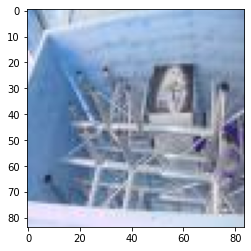

In [198]:
img = cv2.imread(dir_file)
plt.imshow(img)

In [199]:
dir_list

['mini-imagenet/test/trifle/n0761348000000001.jpg',
 'mini-imagenet/test/electric_guitar/n0327201000000004.jpg',
 'mini-imagenet/test/scoreboard/n0414981300000003.jpg',
 'mini-imagenet/test/hourglass/n0354414300000007.jpg',
 'mini-imagenet/test/crate/n0312792500000001.jpg']

In [200]:
dir_list[0]

'mini-imagenet/test/trifle/n0761348000000001.jpg'

In [228]:
acc = pre_acc_class

In [229]:
acc 

array(['1.0', '0.2', '0.8', '0.8', '0.6'], dtype='<U15')

In [232]:
for a in acc:
    print(type(a))
    num = float(a)


<class 'numpy.str_'>
<class 'numpy.str_'>
<class 'numpy.str_'>
<class 'numpy.str_'>
<class 'numpy.str_'>
